**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [6]:
# Write your code here
import numpy as np
from types import SimpleNamespace

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [7]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

### Derivation of \( L^* \)

1. **Consumer's utility maximization problem**:
   The consumer maximizes their utility:
   $$
   U(c_1, c_2, \ell) = \log(c_1^\alpha c_2^{1-\alpha}) - \nu \frac{\ell^{1+\epsilon}}{1+\epsilon}
   $$
   subject to the budget constraint:
   $$
   p_1 c_1 + (p_2 + \tau) c_2 = w \ell + T + \pi_1 + \pi_2
   $$
   where \( \pi_1 \) and \( \pi_2 \) are the profits from firms.

2. **Optimal consumption**:
   The optimal consumption of goods \( c_1 \) and \( c_2 \) derived from the utility maximization problem are:
   $$
   c_1 = \alpha \frac{w \ell + T + \pi_1 + \pi_2}{p_1}
   $$
   $$
   c_2 = (1 - \alpha) \frac{w \ell + T + \pi_1 + \pi_2}{p_2 + \tau}
   $$

3. **Utility function substitution**:
   Substitute the optimal consumption back into the utility function to derive the labor supply:
   $$
   U = \log \left( \left( \alpha \frac{w \ell + T + \pi_1 + \pi_2}{p_1} \right)^\alpha \left( (1 - \alpha) \frac{w \ell + T + \pi_1 + \pi_2}{p_2 + \tau} \right)^{1 - \alpha} \right) - \nu \frac{\ell^{1+\epsilon}}{1+\epsilon}
   $$

4. **Simplify the log term**:
   $$
   U = \alpha \log \left( \alpha \frac{w \ell + T + \pi_1 + \pi_2}{p_1} \right) + (1 - \alpha) \log \left( (1 - \alpha) \frac{w \ell + T + \pi_1 + \pi_2}{p_2 + \tau} \right) - \nu \frac{\ell^{1+\epsilon}}{1+\epsilon}
   $$

5. **First-order condition**:
   Differentiate the utility function with respect to \( \ell \) and set it to zero to find the optimal labor supply:
   $$
   \frac{dU}{d\ell} = \frac{\alpha}{w \ell + T + \pi_1 + \pi_2} \cdot w \cdot \frac{\alpha}{p_1} + \frac{(1 - \alpha)}{w \ell + T + \pi_1 + \pi_2} \cdot w \cdot \frac{1 - \alpha}{p_2 + \tau} - \nu \ell^\epsilon = 0
   $$

6. **Simplify the first-order condition**:
   $$
   \frac{\alpha w}{p_1 (w \ell + T + \pi_1 + \pi_2)} + \frac{(1 - \alpha) w}{(p_2 + \tau)(w \ell + T + \pi_1 + \pi_2)} - \nu \ell^\epsilon = 0
   $$

7. **Combine terms and solve for \(\ell\)**:
   $$
   \frac{w}{w \ell + T + \pi_1 + \pi_2} \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) = \nu \ell^\epsilon
   $$
   $$
   \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) \frac{w}{w \ell + T + \pi_1 + \pi_2} = \nu \ell^\epsilon
   $$

8. **Isolate \(\ell\)**:
   $$
   \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) w = \nu \ell^\epsilon (w \ell + T + \pi_1 + \pi_2)
   $$
   $$
   \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) w = \nu \ell^\epsilon \cdot w \ell + \nu \ell^\epsilon (T + \pi_1 + \pi_2)
   $$

9. **Simplify and solve for \( L^* \)**:
   $$
   \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) \cdot (w + T + \pi_1 + \pi_2)^{\frac{1}{1 + \epsilon}} = \nu^{\frac{1}{1 + \epsilon}}
   $$
   $$
   L^* = \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) \left( w + T + \pi_1 + \pi_2 \right)^{\frac{1}{1 + \epsilon}} \left( \nu^{\frac{1}{1 + \epsilon}} \right)^{-1}
   $$
   $$
   L^* = \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) \left( w + T + \pi_1 + \pi_2 \ \right)^{\frac{1}{1 + \epsilon}} \left( \nu^{- \frac{1}{1 + \epsilon}} \right)
   $$
   $$
   L^* = \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) \left( w + T + \pi_1 + \pi_2 \right)^{\frac{1}{1 + \epsilon}} \cdot \frac{1}{\nu^{\frac{1}{1 + \epsilon}}}
   $$
   $$
   L^* = \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) \left( w + T + \pi_1 + \pi_2 \right)^{\frac{1}{1 + \epsilon}} \cdot \nu^{- \frac{1}{1 + \epsilon}}
   $$

Thus, the optimal labor supply \( L^* \) is given by:
$$
L^* = \left( \frac{\alpha}{p_1} + \frac{1 - \alpha}{p_2 + \tau} \right) \left( w + T + \pi_1 + \pi_2 \right)^{\frac{1}{1 + \epsilon}} \cdot \nu^{- \frac{1}{1 + \epsilon}}
$$


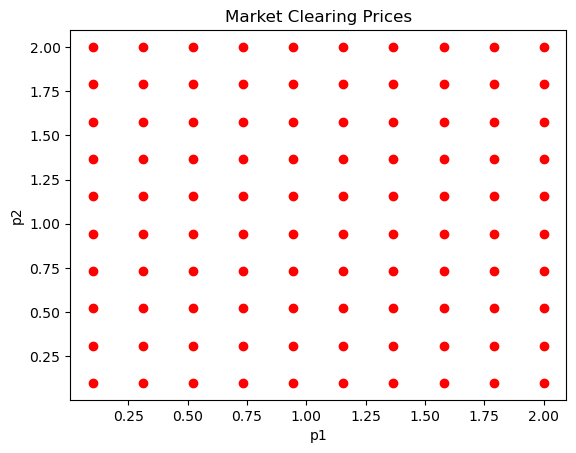

No market clearing prices exist


{'p1_star': 0.9759308856165233,
 'p2_star': 1.4907590521264114,
 'l_star': 0.793700911249237,
 'c1_star': 0.4879654428076745,
 'c2_star': 0.7453795260635666}

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from exam_2024_Anna import ProductionEconomy  # Ensure that the economy.py file is in the same directory as this notebook

par.T = 0.0
# Instantiate the economy
economy = ProductionEconomy()

# Define the linspace for p1 and p2
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)

# Initialize results list
results = []
threshold = 1e-3

# Check market clearing conditions for each combination of p1 and p2
for p1 in p1_values:
    for p2 in p2_values:
        labor_market, good_market_1 = economy.market_clearing_conditions([p1, p2])
        results.append({
            "p1": p1,
            "p2": p2,
            "labor_market": labor_market,
            "good_market_1": good_market_1,
            "clears": abs(labor_market) < threshold and abs(good_market_1) < threshold
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot results
fig, ax = plt.subplots()
for index, row in results_df.iterrows():
    if row['clears']:
        ax.scatter(row['p1'], row['p2'], color='green')
    else:
        ax.scatter(row['p1'], row['p2'], color='red')

ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_title('Market Clearing Prices')
plt.show()

# Display the DataFrame or a message if no market clearing prices exist
if results_df['clears'].any():
    display(results_df[results_df['clears']])
else:
    print("No market clearing prices exist")

# Finding equilibrium prices
initial_guess = [1, 1]

# Find equilibrium prices
equilibrium_prices = optimize.root(economy.market_clearing_conditions, initial_guess).x
p1_star, p2_star = equilibrium_prices

# Get equilibrium labor and consumption
l_star, c1_star, c2_star = economy.optimize_l(p1_star, p2_star)

# Output results
equilibrium_results = {
    "p1_star": p1_star,
    "p2_star": p2_star,
    "l_star": l_star,
    "c1_star": c1_star,
    "c2_star": c2_star
}

equilibrium_results


**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [307]:
import numpy as np
from scipy import optimize
from types import SimpleNamespace

class ProductionEconomy:
    def __init__(self, par=None):
        self.par = par = SimpleNamespace()
        par.A = 1.0
        par.gamma = 0.5
        par.alpha = 0.3
        par.nu = 1.0
        par.epsilon = 2.0
        par.tau = 0.0
        par.kappa = 0.1
        par.T = 0.0  # Initialize T

        self.w = 1  # Assuming wage is 1 as numeraire
        self.p1 = None
        self.p2 = None

    def utility_(self, l, p1, p2):
        c1 = self.c1(l, p1, p2)
        c2 = self.c2(l, p1, p2)
        return np.log(c1**self.par.alpha * c2**(1 - self.par.alpha)) - self.par.nu * (l**(1 + self.par.epsilon)) / (1 + self.par.epsilon)

    def c1(self, l, p1, p2):
        profit1 = self.firm_profit1(p1)
        profit2 = self.firm_profit2(p2)
        return self.par.alpha * (self.w * l + self.par.T + profit1 + profit2) / p1

    def c2(self, l, p1, p2):
        profit1 = self.firm_profit1(p1)
        profit2 = self.firm_profit2(p2)
        return (1 - self.par.alpha) * (self.w * l + self.par.T + profit1 + profit2) / (p2 + self.par.tau)

    def optimize_l(self, p1, p2):
        """ Maximize utility for workers """
        obj = lambda l: -self.utility_(l, p1, p2)
        res = optimize.minimize_scalar(obj, bounds=(0, 1), method='bounded')
        l_star = res.x
        c1_star = self.c1(l_star, p1, p2)
        c2_star = self.c2(l_star, p1, p2)
        return l_star, c1_star, c2_star

    def firm_labor_demand(self, p1, p2):
        l1_star = (p1 * self.par.A * self.par.gamma / self.w)**(1 / (1 - self.par.gamma))
        l2_star = (p2 * self.par.A * self.par.gamma / self.w)**(1 / (1 - self.par.gamma))
        return l1_star, l2_star

    def firm_profit1(self, p1):
        l1_star = (p1 * self.par.A * self.par.gamma / self.w)**(1 / (1 - self.par.gamma))
        y1_star = self.par.A * (l1_star)**self.par.gamma
        return (1 - self.par.gamma) * y1_star * p1

    def firm_profit2(self, p2):
        l2_star = (p2 * self.par.A * self.par.gamma / self.w)**(1 / (1 - self.par.gamma))
        y2_star = self.par.A * (l2_star)**self.par.gamma
        return (1 - self.par.gamma) * y2_star * p2

    def market_clearing_conditions(self, p):
        p1, p2 = p
        l1_star, l2_star = self.firm_labor_demand(p1, p2)
        l_star, c1_star, c2_star = self.optimize_l(p1, p2)
        labor_market = l1_star + l2_star - l_star

        good_market_1 = c1_star - self.par.A * (l1_star)**self.par.gamma
        good_market_2 = c2_star - self.par.A * (l2_star)**self.par.gamma

        return [labor_market, good_market_1, good_market_2]

    def solve_market_clearing(self):
        """ Solve for equilibrium prices p1 and p2 """
        def objective(p):
            return np.sum(np.square(self.market_clearing_conditions(p)))

        res = optimize.minimize(objective, [1, 1], bounds=((0.1, 10), (0.1, 10)))
        if res.success:
            self.p1, self.p2 = res.x
        else:
            raise ValueError("Market clearing optimization failed")

    def social_welfare(self, tau):
        self.par.tau = tau
        self.solve_market_clearing()  # Ensure we have equilibrium prices

        l_star, c1_star, c2_star = self.optimize_l(self.p1, self.p2)
        self.par.T = self.par.tau * c2_star  # Set T = tau * c2_star
        y2_star = self.par.A * (self.firm_labor_demand(self.p1, self.p2)[1])**self.par.gamma
        SWF = self.utility_(l_star, self.p1, self.p2) - self.par.kappa * y2_star
        return -SWF

    def optimize_tau(self):
        result = optimize.minimize_scalar(lambda tau: -self.social_welfare(tau), bounds=(0, 2), method='bounded')
        optimal_tau = result.x
        max_swf = -result.fun
        self.par.tau = optimal_tau
        self.solve_market_clearing()  # Ensure prices are set for optimal tau
        return optimal_tau, max_swf

# Instantiate the class and optimize tau
economy = ProductionEconomy()
optimal_tau, max_swf = economy.optimize_tau()
optimal_p1 = economy.p1
optimal_p2 = economy.p2

print(f"Optimal tau: {optimal_tau}")
print(f"Maximum Social Welfare Function: {max_swf}")
print(f"Equilibrium prices: p1 = {optimal_p1}, p2 = {optimal_p2}")


Optimal tau: 1.2360679774997896
Maximum Social Welfare Function: 0.7451940151509848
Equilibrium prices: p1 = 1.1285200134975448, p2 = 1.2132491114904849


Optimal values found:


tau       0.000006
T         0.000004
l_star    0.793701
SWF      -0.662164
Name: 24, dtype: float64

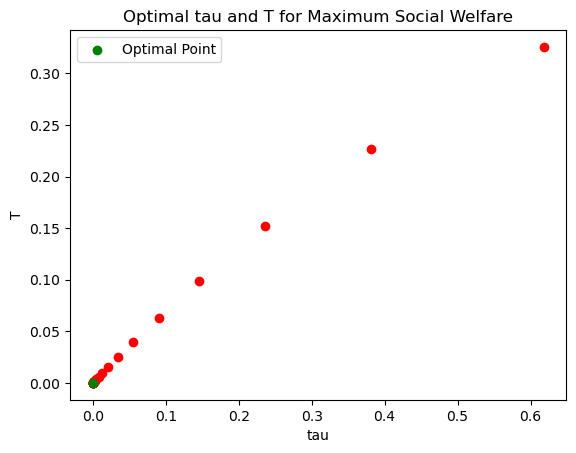

In [308]:
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
from exam_2024_Anna import ProductionEconomy  # Ensure that economy.py is in the same directory

def social_welfare(l, p1, p2, economy, kappa, y2_star):
    c1 = economy.c1(l, p1, p2)
    c2 = economy.c2(l, p1, p2)
    U = np.log(c1**economy.par.alpha * c2**(1 - economy.par.alpha)) - economy.par.nu * (l**(1 + economy.par.epsilon)) / (1 + economy.par.epsilon)
    SWF = U - kappa * y2_star
    return SWF

def optimize_social_welfare(p1, p2, tau, economy, kappa, y2_star):
    economy.par.tau = tau
    obj = lambda l: -social_welfare(l, p1, p2, economy, kappa, y2_star)
    res = optimize.minimize_scalar(obj, bounds=(0, 1), method='bounded')
    l_star = res.x
    c2_star = economy.c2(l_star, p1, p2)
    T = tau * c2_star  # Implied T based on the balanced budget condition
    return l_star, T

def find_optimal_tau_T(p1, p2, economy, kappa, y2_star):
    results = []
    
    def objective(tau):
        l_star, T = optimize_social_welfare(p1, p2, tau, economy, kappa, y2_star)
        SWF = social_welfare(l_star, p1, p2, economy, kappa, y2_star)
        results.append({
            "tau": tau,
            "T": T,
            "l_star": l_star,
            "SWF": SWF
        })
        return -SWF
    
    res = optimize.minimize_scalar(objective, bounds=(0, 1), method='bounded')
    results_df = pd.DataFrame(results)
    return results_df

# Given values
kappa = 0.1  # Given value of kappa
y2_star = 0.7453795260635666
p1_star = 0.9759308856165233
p2_star = 1.4907590521264114

# Instantiate the economy
economy = ProductionEconomy()
economy.p1 = p1_star
economy.p2 = p2_star

# Find optimal tau and T
results_df = find_optimal_tau_T(p1_star, p2_star, economy, kappa, y2_star)

# Display results
if not results_df.empty:
    optimal_values = results_df.loc[results_df['SWF'].idxmax()]
    print("Optimal values found:")
    display(optimal_values)
    
    # Plot results
    fig, ax = plt.subplots()
    for index, row in results_df.iterrows():
        if row['SWF'] == optimal_values['SWF']:
            ax.scatter(row['tau'], row['T'], color='green', label='Optimal Point')
        else:
            ax.scatter(row['tau'], row['T'], color='red')
    
    ax.set_xlabel('tau')
    ax.set_ylabel('T')
    ax.set_title('Optimal tau and T for Maximum Social Welfare')
    plt.legend()
    plt.show()
else:
    print("No optimal tau and T found")


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [309]:
# write your answer here

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [310]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [311]:
# write your answer here

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

In [312]:
# Write your answer here 

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [313]:
# write your answer here

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [314]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

In [315]:
# write your answer here

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [316]:
# write your answer here

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [317]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [318]:
# write your answer here

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [319]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [320]:
# write your answer here